#**Object Detection**#


#*R-CNN*#

Одним из первых подходов, применимых для определения нахождения объекта на картинке, является R-CNN (Region Convolution Neural Network).
Архитектура состоит из нескольких шагов:
 - Определение набора гипотез.
 - Извлечение из предполагаемых регионов признаков с помощью сверточной нейронной сети и их кодирование в вектор.
 - Классификация объекта внутри гипотезы на основе вектора из шага 2.
 - Улучшение (корректировка) координат гипотезы.
 - Все повторяется, начиная с шага 2, пока не будут обработаны все гипотезы с шага 1.






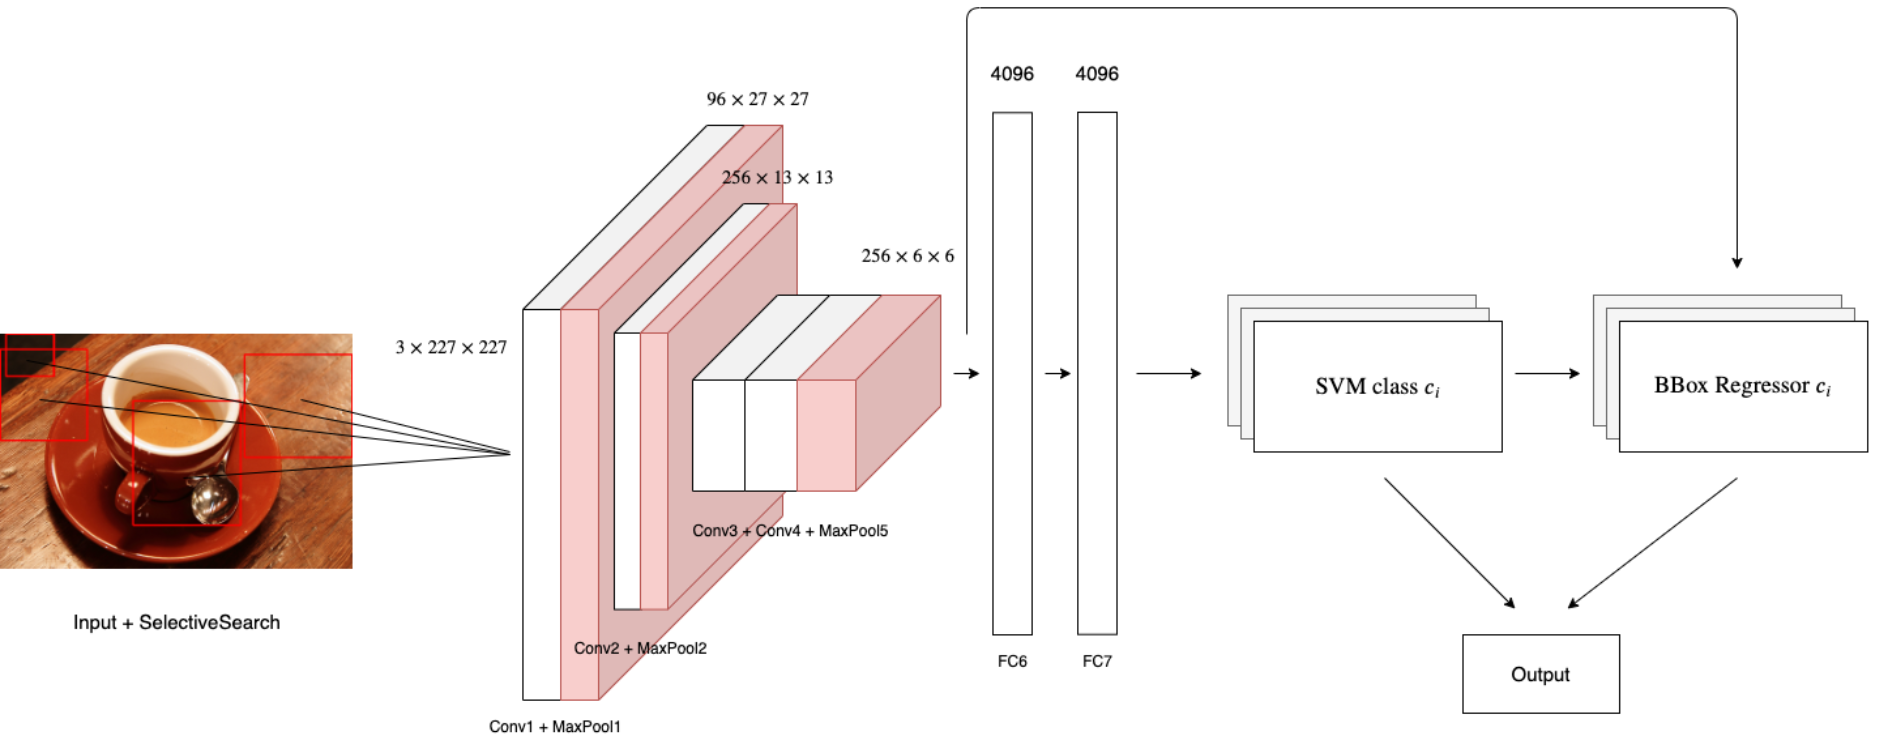

##**Терминология**##

- Ограничивающая рамка (bounding box) – координаты, ограничивающие определенную область изображения, – чаще всего в форме прямоугольника. Может быть представлена 4 координатами в двух форматах: центрированный ($c_{x},c_{y},w,h$) и обычный ($x_{min},y_{min},x_{max},y_{max}$).

- Гипотеза (Proposal), P – определенный регион изображения (заданный с помощью ограничивающей рамки), в котором предположительно находится объект.

- End-to-end обучение – обучение, при котором на вход сети поступают сырые изображения, а на выходе – готовые ответы.

- IoU (Intersection-over-Union) – метрика степени пересечения между двумя ограничивающими рамками. Гипотезы, содержащие объекты, будем называть позитивными (positive), а без объектов (содержащие только фон, или незначительную часть объекта) – негативными (negative).

Для того, чтобы в последующем определить пересечения между двумя регионами изображения будет использоваться метрика Intersection over Union. Она считается довольно просто: площадь пересечения двух областей делится на общую площадь регионов.

С позитивными гипотезами все понятно – если класс определен неверно, нужно штрафовать. Но как быть с негативными? Их намного больше, чем позитивных… Для начала отметим, что не все негативные гипотезы одинаково сложно распознавать. Например, случаи, содержащие только фон (easy negative) гораздо проще классифицировать, чем содержащие другой объект или малую часть нужного (hard negative).

На практике easy negative и hard negative определяются по пересечению ограничивающей рамки (как раз используется Intersection over Union) с правильным положением объекта на изображении. Например, если пересечения нет, или оно крайне мало – это easy negative ($C_{i}=0$), если большое – это hard negative или positive.

Подход Hard Negative Mining предлагает использовать для обучения только hard negative, поскольку, научившись распознавать их, мы автоматический добиваемся наилучшей работы с easy negative гипотезами. Но такая идеология будет применяться только в последующих реализациях (начиная с Fast R-CNN).



#*Object Detection. Square Detection*#

#Libs#

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import json
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn.functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
import torchvision.transforms as T

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
!ls /content/drive/MyDrive/square_circle_test/images

02f77044-test_image_84.png  5d55705b-test_image_27.png	af9aa8b3-test_image_11.png
0748f028-test_image_35.png  5f43587a-test_image_93.png	b4b77b69-test_image_90.png
08cf28a2-test_image_51.png  5fc9ceac-test_image_2.png	baac27a5-test_image_49.png
0e03bc5a-test_image_62.png  60ecbb5a-test_image_40.png	be313b11-test_image_9.png
0ef51f0a-test_image_71.png  61085123-test_image_60.png	c2b9ff63-test_image_95.png
1184b165-test_image_22.png  6194cae4-test_image_68.png	c366dde5-test_image_82.png
1204e540-test_image_59.png  61967b5f-test_image_73.png	c5958d29-test_image_86.png
126b94d9-test_image_6.png   652e5c3b-test_image_88.png	c643f285-test_image_43.png
1a6f02a7-test_image_5.png   679d8ada-test_image_94.png	c9d366c5-test_image_85.png
203d2fc1-test_image_13.png  68a42605-test_image_78.png	c9fa5b2f-test_image_99.png
23836074-test_image_79.png  6ced8d6a-test_image_65.png	ca5848bf-test_image_54.png
268fb83a-test_image_76.png  6d77cfe6-test_image_29.png	ccd082fd-test_image_37.png
26c2ead2-test_imag

In [67]:
def load_image(image_path):
    image = Image.open(image_path)
    # Определение трансформации (если требуется)
    transform = transforms.Compose([
    transforms.ToTensor()
        ])
    image_tensor = transform(image)
    # Просмотр информации
    print("Размерность тензора изображения:", image_tensor.size())
    print("Ширина изображения:", image_tensor.size(2))
    print("Высота изображения:", image_tensor.size(1))
    print("Количество каналов:", image_tensor.size(0))


image_path = '/content/drive/MyDrive/square_circle/images/9932f8f9-image_30.png'
load_image(image_path)

Размерность тензора изображения: torch.Size([1, 32, 32])
Ширина изображения: 32
Высота изображения: 32
Количество каналов: 1


In [68]:
import torch
torch.cuda.is_available()

True

In [69]:
!nvidia-smi

Thu Jul 18 09:07:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0              29W /  70W |   3855MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#Dataset#

In [70]:
class SquareDataset(Dataset):
    def __init__(self, images_folder, annotations_file, transform=None):
        self.images_folder = images_folder
        self.annotations = json.load(open(annotations_file))
        self.transform = transform

    def __len__(self):
        return len(self.annotations['images'])

    def __getitem__(self, idx):
        img_info = self.annotations['images'][idx]
        img_name = os.path.join(self.images_folder, img_info['file_name'])
        image = Image.open(img_name)

        boxes = []
        labels = []
        for annotation in self.annotations['annotations']:
            if annotation['image_id'] == img_info['id'] and annotation['category_id'] == 1:  # Фильтруем только квадраты
                boxes.append(annotation['bbox'])  # [x_min, y_min, width, height]
                labels.append(annotation['category_id'])

        if boxes:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        if self.transform:
            image = self.transform(image)


        target = {
            "boxes": boxes,
            "labels": labels  # Метки категорий
        }

        return image, target

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

In [71]:
# Функция для отображения данных
def show_dataset_samples(dataset, num_samples=5):
    for i in range(num_samples):
        image, target = dataset[i]
        plt.figure()
        plt.imshow(image.permute(1, 2, 0))
        for box in target['boxes']:
            x_min, y_min, width, height = box
            rect = plt.Rectangle((x_min, y_min), width, height, fill=False, color='red')
            print(box)
            print(target['labels'])
            plt.gca().add_patch(rect)
        plt.show()

In [72]:
transform = transforms.Compose([
    transforms.ToTensor()
])


dataset = SquareDataset(images_folder='/content/drive/MyDrive/square_circle',
                        annotations_file='/content/drive/MyDrive/square_circle/result.json',
                        transform=transform)

print(transform)

Compose(
    ToTensor()
)


tensor([ 9.4359, 15.5524, 11.4126, 11.0396])
tensor([1])


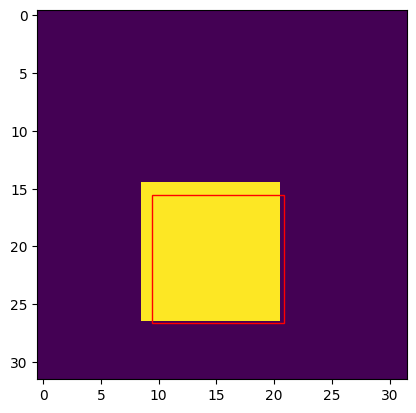

tensor([20.8858, 18.3869, 10.2191,  9.7716])
tensor([1])


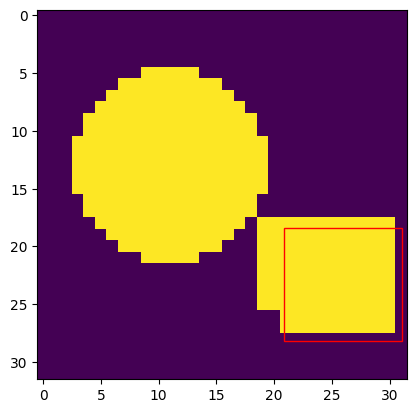

tensor([ 8.9138, 18.2378, 12.1585, 11.6737])
tensor([1])


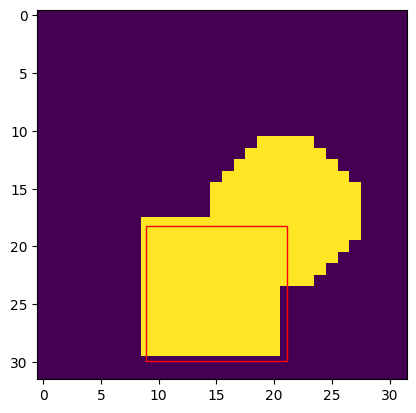

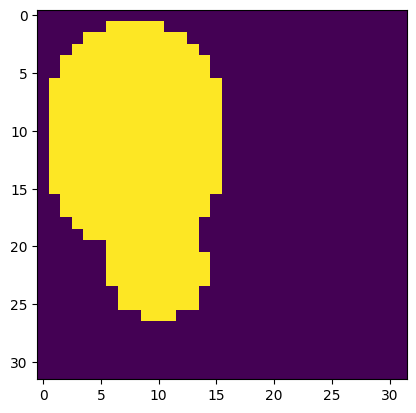

tensor([18.4714, 10.3250, 12.4090, 12.0774])
tensor([1, 1])
tensor([ 8.2411, 19.4660, 12.1721, 12.4090])
tensor([1, 1])


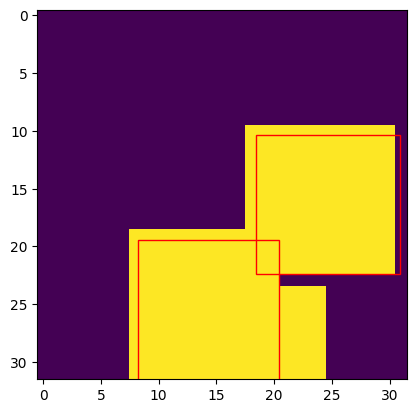

In [73]:
# Отображение первых 5 образцов
show_dataset_samples(dataset, num_samples=5)

In [74]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [75]:
print(len(dataset))

100


In [76]:
for images, targets in dataloader:
    print("Batch of images:", len(images))
    print("Batch of target boxes:", [target["boxes"] for target in targets])
    print("Batch of target labels:", [target["labels"].size() for target in targets])

Batch of images: 4
Batch of target boxes: [tensor([[18.2005, 13.1655, 12.9417, 12.5688]]), tensor([[15.1049, 11.4126, 11.8601, 11.4499]]), tensor([[11.3753,  9.3240, 12.3823, 10.7786]]), tensor([], size=(0, 4))]
Batch of target labels: [torch.Size([1]), torch.Size([1]), torch.Size([1]), torch.Size([0])]
Batch of images: 4
Batch of target boxes: [tensor([], size=(0, 4)), tensor([], size=(0, 4)), tensor([[20.8112, 15.8508,  9.1002,  8.8765]]), tensor([], size=(0, 4))]
Batch of target labels: [torch.Size([0]), torch.Size([0]), torch.Size([1]), torch.Size([0])]
Batch of images: 4
Batch of target boxes: [tensor([[ 7.6084, 12.9417, 12.8671, 10.8904]]), tensor([[12.7925, 22.7879,  8.1678,  8.0186]]), tensor([[ 7.9814, 14.0979, 12.8671, 12.6807]]), tensor([[21.0723, 14.0979, 10.9277, 12.8671]])]
Batch of target labels: [torch.Size([1]), torch.Size([1]), torch.Size([1]), torch.Size([1])]
Batch of images: 4
Batch of target boxes: [tensor([[18.8345, 18.7972, 10.9277, 10.8904]]), tensor([[10.0326,

In [77]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Только два класса: фон и квадрат
num_classes = 1
model = get_model_instance_segmentation(num_classes)
model = model.to('cuda')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
print("Original targets (on CPU):")
for i, t in enumerate(targets):
    print(f"Target {i}:")
    for k, v in t.items():
        print(f"  {k}: {v}")

# Преобразуем targets на GPU
targets_gpu = [{k: v.to('cuda') for k, v in t.items()} for t in targets]

# Выводим преобразованные targets (на GPU)
print("\nConverted targets (on GPU):")
for i, t in enumerate(targets_gpu):
    print(f"Target {i}:")
    for k, v in t.items():
        print(f"  {k}: {v}")

In [ ]:
def check_and_filter_boxes(targets, device='cpu'):
    valid_targets = []
    for t in targets:
        valid_boxes = []
        for box in t['boxes']:
            x_min, y_min, x_max, y_max = box
            if x_max > x_min and y_max > y_min:
                valid_boxes.append(box)
        if valid_boxes:
            valid_boxes_tensor = torch.stack(valid_boxes).to(device)
            valid_targets.append({'boxes': valid_boxes_tensor, 'labels': t['labels'].to(device)})
        else:
            valid_targets.append({'boxes': torch.empty((0, 4), device=device), 'labels': torch.empty(0, dtype=torch.int64, device=device)})
    return valid_targets


# Пример использования функции фильтрации
targets = [
    {'boxes': torch.tensor([[ 7.6084, 12.9417, 12.8671, 10.8904]]), 'labels': torch.tensor([1])},
    {'boxes': torch.tensor([[23.9441, 18.0140,  8.0559,  7.5711]]), 'labels': torch.tensor([1])},
    {'boxes': torch.tensor([[17.9021, 12.0466,  7.0490,  6.9371]]), 'labels': torch.tensor([1])}
]

filtered_targets = check_and_filter_boxes(targets)
print(filtered_targets)


In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in dataloader:
        images = list(image.to('cuda') for image in images)

        # Проверка и фильтрация targets на GPU
        targets_gpu = check_and_filter_boxes(targets, device='cuda:0')

        loss_dict = model(images, targets_gpu)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 0:  # Вывод информации о процессе обучения каждые 10 шагов
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], Loss: {losses.item()}")
        i += 1

    lr_scheduler.step()

print("Training completed.")


In [ ]:
model.eval()
test_dataset = SquareDataset(images_folder='/content/drive/MyDrive/square_circle_test', annotations_file='/content/drive/MyDrive/square_circle_test/result.json', transform=transform)
test_data_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)

for images, targets in test_data_loader:
    images = list(image.to('cuda') for image in images)
    with torch.no_grad():
        predictions = model(images)

    for i, image in enumerate(images):
        print(f"Image {i}:")
        print("Boxes:", predictions[i]['boxes'].cpu().numpy())
        print("Labels:", predictions[i]['labels'].cpu().numpy())
        print("Scores:", predictions[i]['scores'].cpu().numpy())


#Images#

In [ ]:
print(len(dataset))
index = 1# измените индекс для получения другого изображения
image, boxes = dataset[index]
print(image)
print(boxes)

Модель

#Test#

#Result#